# Vectorization
---

## Drive Mounting

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
current_folder = "/content/gdrive/My Drive/Workshop/TOM/"
os.chdir(current_folder)

## Clean Data Loading

In [20]:
import pandas as pd
df = pd.read_csv("repos.csv", encoding="latin1")
df.sample(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,active_lock_reason,assignee,author_association,body,closed_at,comments,comments_url,created_at,draft,events_url,html_url,id,labels_url,locked,milestone,node_id,number,performed_via_github_app,reaction +1,reaction -1,reaction confused,reaction eyes,reaction heart,reaction hooray,reaction laugh,reaction rocket,reaction total_count,reaction url,repository_url,state,timeline_url,title,updated_at,url,clean_title,code_title,clean_body,code_body
5175,5175,NaN,NaN,NONE,\r\nI am using MPAndroidChart in my order. But...,NaN,1,https://api.github.com/repos/PhilJay/MPAndroid...,2020-03-04T09:57:16Z,NaN,https://api.github.com/repos/PhilJay/MPAndroid...,https://github.com/PhilJay/MPAndroidChart/issu...,575271898,https://api.github.com/repos/PhilJay/MPAndroid...,False,NaN,MDU6SXNzdWU1NzUyNzE4OTg=,4834,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/PhilJay/MPAndroid...,https://api.github.com/repos/PhilJay/MPAndroid...,open,https://api.github.com/repos/PhilJay/MPAndroid...,how to remove the line in the background?,2020-03-10T13:18:48Z,https://api.github.com/repos/PhilJay/MPAndroid...,how to remove the line in the,without code,I am using in my But how to remove the line in...,with code
26577,26577,NaN,NaN,MEMBER,We often generate fake exceptions in the HTTP/...,NaN,1,https://api.github.com/repos/netty/netty/issue...,2015-09-25T00:28:20Z,NaN,https://api.github.com/repos/netty/netty/issue...,https://github.com/netty/netty/issues/4274,108240021,https://api.github.com/repos/netty/netty/issue...,False,NaN,MDU6SXNzdWUxMDgyNDAwMjE=,4274,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/netty/netty/issue...,https://api.github.com/repos/netty/netty,open,https://api.github.com/repos/netty/netty/issue...,HTTP/2 Fake Exception,2015-09-25T00:28:30Z,https://api.github.com/repos/netty/netty/issue...,Fake Exception,with code,We often generate fake exceptions in the unit ...,with code


In [21]:
length_before = df.shape[0]
df.dropna(subset=["clean_title"], inplace=True)
length_after = df.shape[0]
print("We droped {} elements of {}".format(length_before - length_after, length_before))

We droped 2715 elements of 34268


In [22]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.head(2)

,active_lock_reason,assignee,author_association,body,closed_at,comments,comments_url,created_at,draft,events_url,html_url,id,labels_url,locked,milestone,node_id,number,performed_via_github_app,reaction +1,reaction -1,reaction confused,reaction eyes,reaction heart,reaction hooray,reaction laugh,reaction rocket,reaction total_count,reaction url,repository_url,state,timeline_url,title,updated_at,url,clean_title,code_title,clean_body,code_body
0,NaN,NaN,NONE,I put the problem in MD,NaN,1,https://api.github.com/repos/spring-projects/s...,2021-12-11T02:13:23Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1077359600,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5ANzPw,28991,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,JDK17 And SpringBoot-3.0.0-SNAPSHOT,2021-12-11T02:16:56Z,https://api.github.com/repos/spring-projects/s...,And,with code,I put the problem in,without code
1,NaN,NaN,NONE,"I cannot include the actual code here, but I w...",NaN,0,https://api.github.com/repos/spring-projects/s...,2021-12-10T22:32:04Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1077283209,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5ANgmJ,28990,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Dev Tools: Request Scoped Bean Not Working Whe...,2021-12-11T00:46:11Z,https://api.github.com/repos/spring-projects/s...,Dev Request Scoped Bean Not Working When Inclu...,with code,I cannot include the actual code but I will cr...,with code


In [23]:
from collections import defaultdict
dicc = defaultdict(int)

for element in df["clean_title"]:
    dicc[str(type(element))] += 1

dicc

defaultdict(int, {"<class 'str'>": 31553})

In [24]:
titles_no_code = df[df["code_title"]=="without code"]
titles_no_code.shape

(17749, 38)

In [25]:
titles_no_code.head(2)

,active_lock_reason,assignee,author_association,body,closed_at,comments,comments_url,created_at,draft,events_url,html_url,id,labels_url,locked,milestone,node_id,number,performed_via_github_app,reaction +1,reaction -1,reaction confused,reaction eyes,reaction heart,reaction hooray,reaction laugh,reaction rocket,reaction total_count,reaction url,repository_url,state,timeline_url,title,updated_at,url,clean_title,code_title,clean_body,code_body
2,NaN,NaN,NONE,I've got a problem from migrating from SB 2.3 ...,NaN,3,https://api.github.com/repos/spring-projects/s...,2021-12-10T09:06:49Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1076600016,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AK5zQ,28977,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,DatabaseInitializationDependencyConfigurer tri...,2021-12-10T14:44:37Z,https://api.github.com/repos/spring-projects/s...,triggers eager initialization of factory beans,without code,got a problem from migrating from to When havi...,with code
3,NaN,NaN,MEMBER,NaN,NaN,3,https://api.github.com/repos/spring-projects/s...,2021-12-10T08:44:05Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1076581722,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AK1Va,28976,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Reinstate support for Spring Data Couchbase,2021-12-10T15:37:23Z,https://api.github.com/repos/spring-projects/s...,Reinstate support for Spring Data Couchbase,without code,NaN,without code


## The Corpus

In [9]:
corpus = [text.lower() for text in titles_no_code["clean_title"].values if text!=""]
print("We are using {} titles of {}".format(len(corpus), titles_no_code.shape[0]))

We are using 17749 titles of 17749


## TF/IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf = TfidfVectorizer(analyzer="word", ngram_range=(1,1), min_df=0)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
print(tfidf_matrix.shape)

(17749, 7929)


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(similarity_matrix.shape)

(17749, 17749)


In [12]:
import numpy as np

weights = similarity_matrix[np.triu_indices(similarity_matrix.shape[0], 1)]
her, hin = np.triu_indices_from(similarity_matrix, 1)

In [13]:
import pandas as pd

graff = pd.DataFrame(data=weights, columns=["weight"])
graff["from"] = her
graff["to"] = hin

In [14]:
# graff.to_csv("graff.csv")

In [14]:
print(graff.shape)

(157504626, 3)


## Exploration

In [3]:
import pandas as pd
graff = pd.read_csv("graff.csv")
print(graff.shape)

(157504626, 4)


In [4]:
twos = graff[graff["weight"]>=float(0.2)]
sixes = graff[graff["weight"]>=float(0.6)]
sevens = graff[graff["weight"]>=float(0.7)]
eights = graff[graff["weight"]>=float(0.8)]
nines = graff[graff["weight"]>=float(0.9)]

In [6]:
print(twos.shape)
print(sixes.shape)
print(sevens.shape)
print(eights.shape)
print(nines.shape)

(835541, 4)
(16019, 4)
(9774, 4)
(6620, 4)
(5070, 4)


### Similar Issues ($\geq 0.2$)

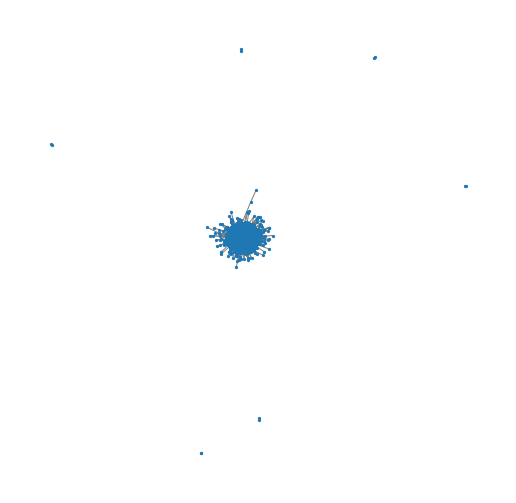

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

U = nx.from_pandas_edgelist(twos, source="from", target="to", edge_attr="weight")
nx.draw(U, pos=nx.spring_layout(U, seed=7), node_size=5, edge_color="gray", alpha=1)

### Similar Issues ($\geq 0.8$)

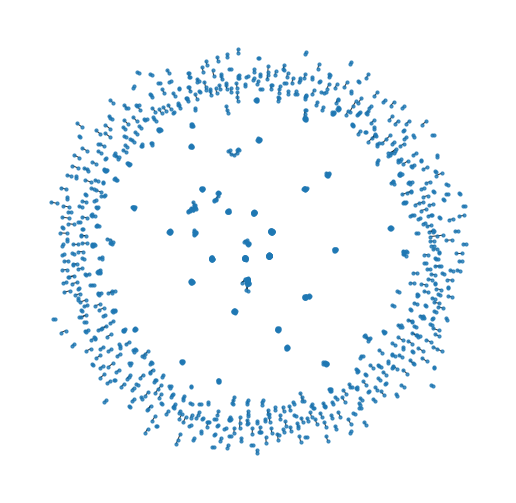

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

V = nx.from_pandas_edgelist(eights, source="from", target="to", edge_attr="weight")
nx.draw(V, pos=nx.spring_layout(V, seed=7), node_size=10, edge_color="k", alpha=0.8)

### Similar Issues ($\geq 0.9$)

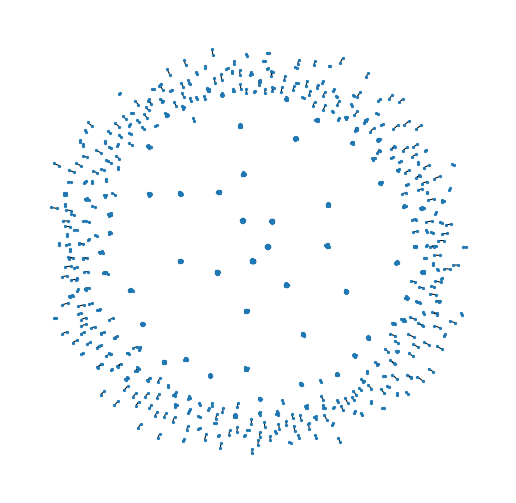

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

W = nx.from_pandas_edgelist(nines, source="from", target="to", edge_attr="weight")
nx.draw(W, pos=nx.spring_layout(W, seed=7), node_size=5, edge_color="k", alpha=1)

### Similar Issues

* Blue: $\geq 0.7$
* Red: $\geq 0.8$
* Green: $\geq 0.9$

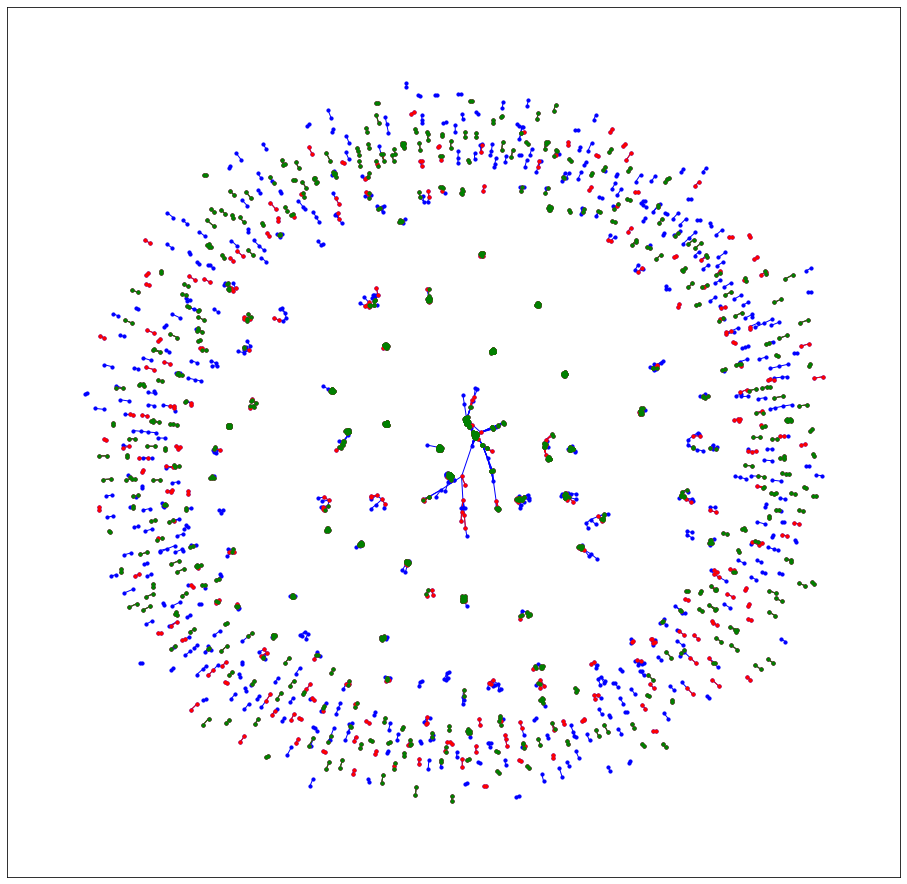

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,16))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

G = nx.Graph()
G.add_edges_from(U.edges)
G.add_edges_from(V.edges)
G.add_edges_from(W.edges)

pos = nx.spring_layout(G, seed=7)

nx.draw_networkx_nodes(U, pos=pos, nodelist=U.nodes, node_color="blue", node_size=10)
nx.draw_networkx_nodes(V, pos=pos, nodelist=V.nodes, node_color="red", node_size=10)
nx.draw_networkx_nodes(W, pos=pos, nodelist=W.nodes, node_color="green", node_size=10)

nx.draw_networkx_edges(U, pos=pos, nodelist=U.edges, alpha=1, edge_color="blue");
nx.draw_networkx_edges(V, pos=pos, nodelist=V.edges, alpha=1, edge_color="red");
nx.draw_networkx_edges(W, pos=pos, nodelist=G.edges, alpha=1, edge_color="green");
# nx.draw(W, pos=nx.circular_layout(W))

## Communities ($\geq 0.2$)

In [9]:
import community.community_louvain as clouvain
partition = clouvain.best_partition(U)
modularity = clouvain.modularity(partition, U)

In [10]:
print(type(partition), type(modularity))
pos = nx.spring_layout(U, dim=2)
community_id = [partition[node] for node in U.nodes()]

<class 'dict'> <class 'float'>


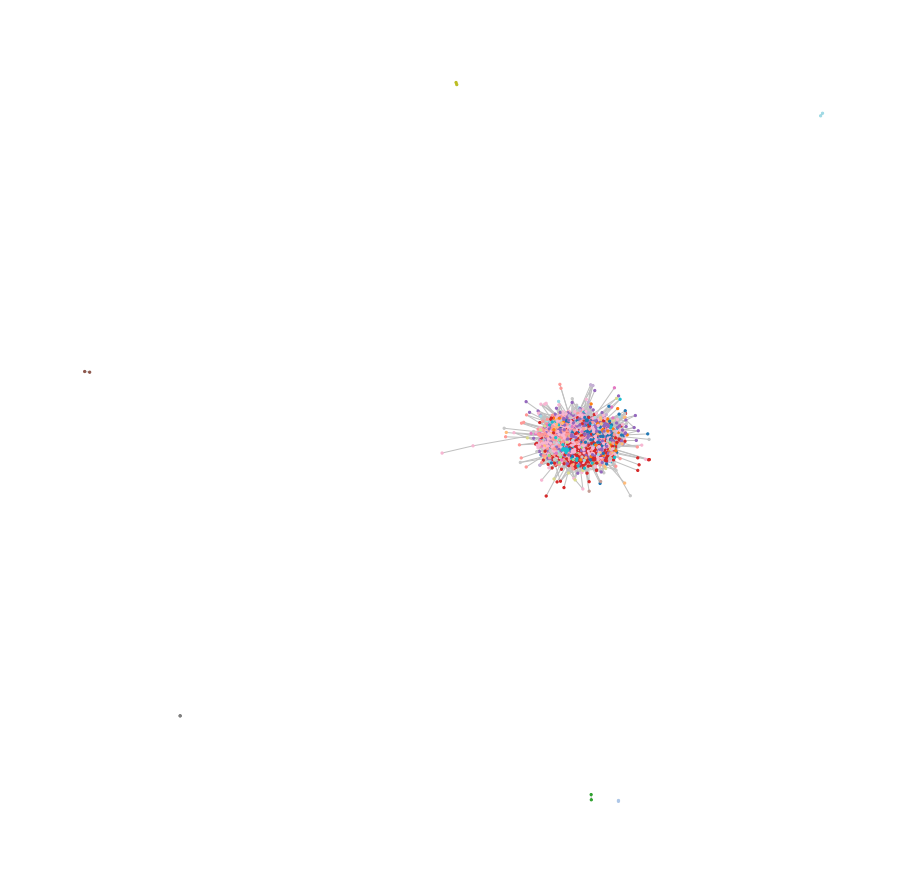

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

nx.draw(U, pos=pos, edge_color=['silver']*len(U.edges()), 
        cmap=plt.cm.tab20, node_color=community_id, node_size=5, alpha=1)

In [12]:
type(community_id), len(community_id)

(list, 17570)

In [13]:
from collections import defaultdict
elements_per_communities = defaultdict(int)
for element in community_id:
    elements_per_communities[str(element)] += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  """


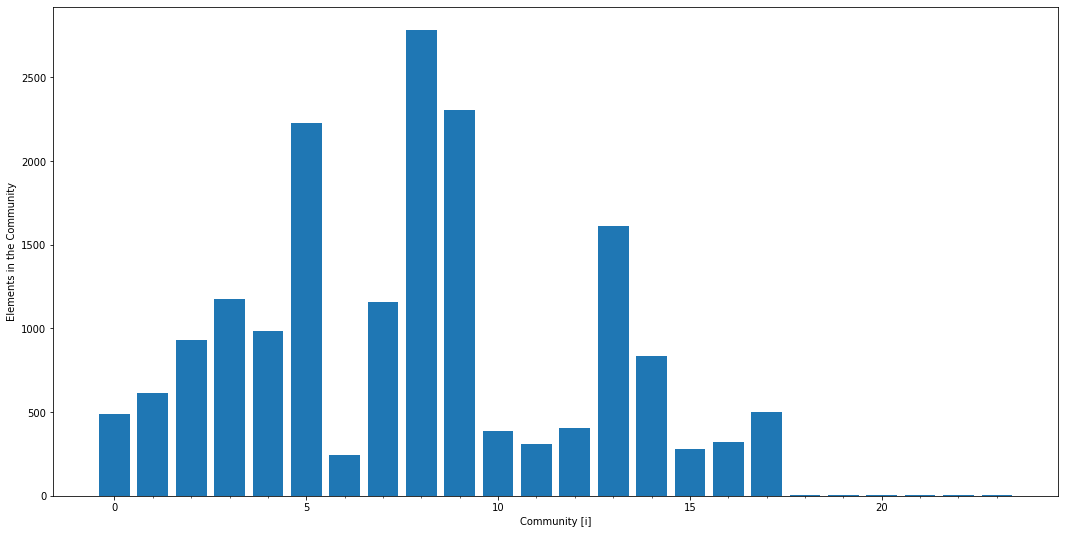

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)
ax.bar(range(len(elements_per_communities)), list(elements_per_communities.values()), align='center')
ax.set_xticks(range(len(elements_per_communities)), list(elements_per_communities.keys()))
ax.set_ylabel("Elements in the Community")
ax.set_xlabel("Community [i]")
plt.show()

In [18]:
# import pickle

# with open('big_communities.pickle', 'wb') as handle:
#     pickle.dump(partition, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
wbuch = dict()

for key in range(titles_no_code.shape[0]):
    try:
        wbuch[key] = partition[key]
    except:
        wbuch[key] = -1

In [27]:
titles_no_code["commies"] = wbuch.values()
titles_no_code.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,active_lock_reason,assignee,author_association,body,closed_at,comments,comments_url,created_at,draft,events_url,html_url,id,labels_url,locked,milestone,node_id,number,performed_via_github_app,reaction +1,reaction -1,reaction confused,reaction eyes,reaction heart,reaction hooray,reaction laugh,reaction rocket,reaction total_count,reaction url,repository_url,state,timeline_url,title,updated_at,url,clean_title,code_title,clean_body,code_body,commies
2,NaN,NaN,NONE,I've got a problem from migrating from SB 2.3 ...,NaN,3,https://api.github.com/repos/spring-projects/s...,2021-12-10T09:06:49Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1076600016,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AK5zQ,28977,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,DatabaseInitializationDependencyConfigurer tri...,2021-12-10T14:44:37Z,https://api.github.com/repos/spring-projects/s...,triggers eager initialization of factory beans,without code,got a problem from migrating from to When havi...,with code,21
3,NaN,NaN,MEMBER,NaN,NaN,3,https://api.github.com/repos/spring-projects/s...,2021-12-10T08:44:05Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1076581722,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AK1Va,28976,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Reinstate support for Spring Data Couchbase,2021-12-10T15:37:23Z,https://api.github.com/repos/spring-projects/s...,Reinstate support for Spring Data Couchbase,without code,NaN,without code,3


In [28]:
# titles_no_code.to_csv("titles_no_code_commies.csv")

### Community Samples

In [30]:
titles_no_code[titles_no_code["commies"]==0]["clean_title"].sample(20)

11532                         kudu connector for sercurity
30159                          Realm with explicit timeout
11263    Druid connector could not handle union more th...
32483    exceptions during test running actions lead to...
11636    Presto incorrectly truncates numeric values to...
29552    scale listener does not fire for resting position
8161                      Event subprocess start by signal
11251                                            on Presto
18418                                       best practices
3554                     Implement mechanism for migration
12115    implement method instead of hiding non support...
10960                                            Implement
11367    Implement range filter pushdown for subfields ...
10957                  when querying tables with connector
30074             Realm sum from inner relationship fields
18502                             Implement Happy Eyeballs
11531    User defined databases has not listed while us.

In [31]:
titles_no_code[titles_no_code["commies"]==1]["clean_title"].sample(20)

10141    protection should not create a session if sess...
11309    Create a new that can arrange buffers accordin...
3248                                    and slow query log
15658                              Table mapping breaks on
1840                                  introduce big arrays
10703                  Refactor path for materialized view
9408     Create and based on track type instead of rend...
4472                         Create notification endpoints
30299                                             refactor
29012                                               paging
29286                                       jetpack paging
11831                                            Lock info
21858               Changed cluster session initialization
33041       Refactor preconditions with a message supplier
17146         aggregates definition in multimodule project
17722                      Runtime Reconfiguration pattern
3832                          Create an to manage synony

In [33]:
titles_no_code[titles_no_code["commies"]==3]["clean_title"].sample(20)

8700                               Does not support Sleuth
18278                                   support of clients
4740     Support to construct result maps by using anno...
30285           Support queries across backlinks using the
11654                                     Variable support
32941               Support annotations in generated field
4805                             Support of nested cursors
10897                 Constraint Support and Optimizations
17695                                         architecture
18634             Add support for reflection access filter
249              Support file for configuration properties
34122                     Kotlin Infix Support for Inserts
4745                                           Support the
32218              Support building Android apps with asan
30414            Interprocess support for encrypted Realms
14831                  Add retry support for eureka client
20954       Better Theories support for generative testi

In [35]:
titles_no_code[titles_no_code["commies"]==4]["clean_title"].sample(20)

4883         Move highlighter when x or Y value is updated
126                     Example log output is inconsistent
16364                            Auto indentation behavior
21544    Reactor integration always propagates errors t...
19335                  Extract everything between comments
21505                                 Inaccurate Rendering
23718    Improve efficiency of bulk removals in transfo...
33636                            Integrate cluster library
6680                                           About click
19860           Increased query performance for some cases
3376                    about token offset during indexing
12412                                        Improve tests
5665                                Improve Color Template
19380                          Method naming inconsistency
20921    Javadoc folder should not contain beta documen...
21095                              Container Spec builders
9869                      Clean up Reference Documentati

## Communities ($\geq 0.8$)

In [17]:
import community.community_louvain as clouvain
partition = clouvain.best_partition(V)
modularity = clouvain.modularity(partition, V)

In [18]:
print(type(partition), type(modularity))
pos = nx.spring_layout(V, dim=2)
community_id = [partition[node] for node in V.nodes()]

<class 'dict'> <class 'float'>


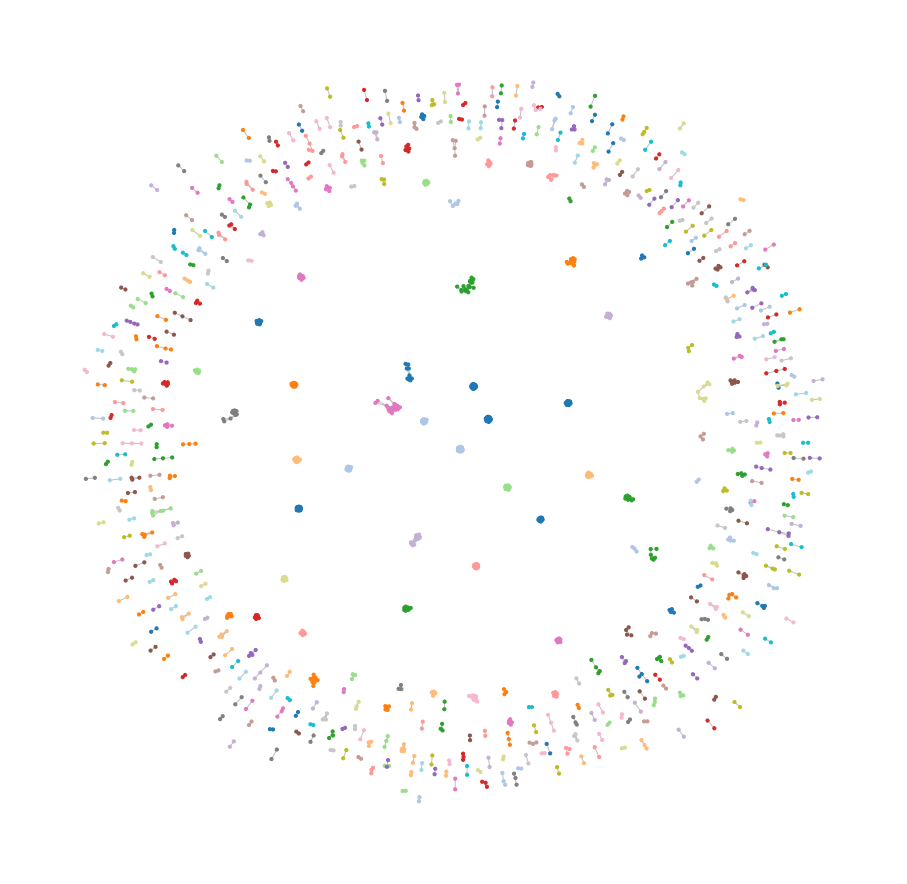

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

nx.draw(V, pos=pos, edge_color=['silver']*len(V.edges()), 
        cmap=plt.cm.tab20, node_color=community_id, node_size=10, alpha=1)

In [20]:
from collections import defaultdict
elements_per_communities = defaultdict(int)
for element in community_id:
    elements_per_communities[str(element)] += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  """


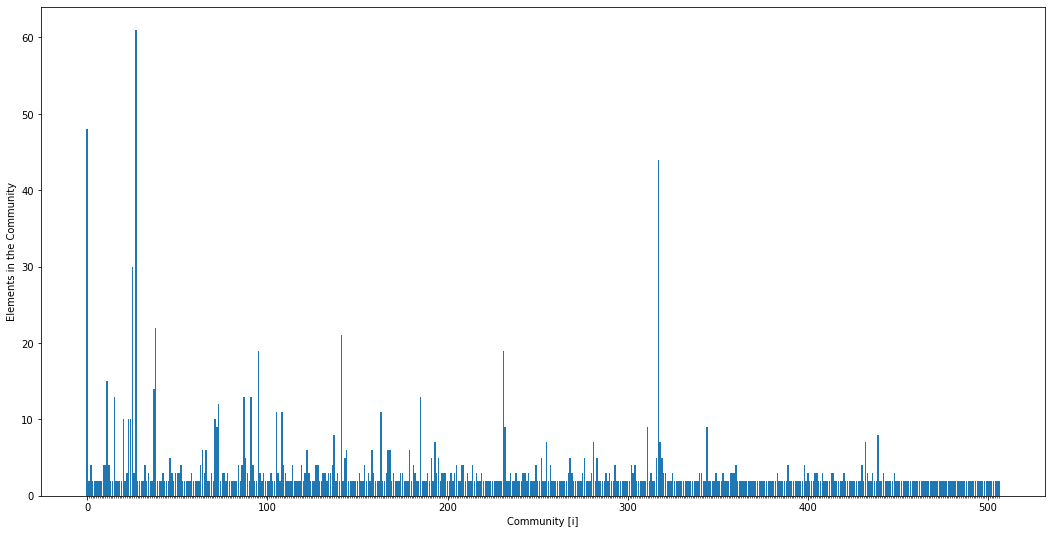

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)
ax.bar(range(len(elements_per_communities)), list(elements_per_communities.values()), align='center')
ax.set_xticks(range(len(elements_per_communities)), list(elements_per_communities.keys()))
ax.set_ylabel("Elements in the Community")
ax.set_xlabel("Community [i]")
plt.show()

## Communities ($\geq 0.9$)

In [22]:
import community.community_louvain as clouvain
partition = clouvain.best_partition(W)
modularity = clouvain.modularity(partition, W)

In [23]:
print(type(partition), type(modularity))
pos = nx.spring_layout(W, dim=2)
community_id = [partition[node] for node in W.nodes()]

<class 'dict'> <class 'float'>


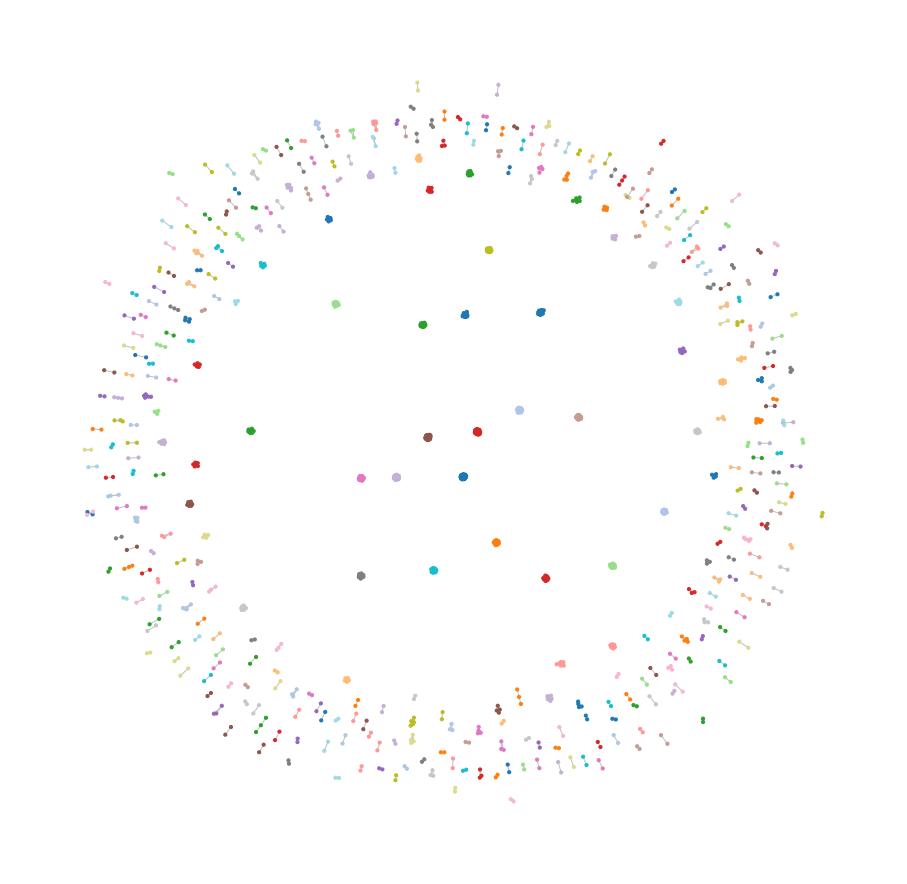

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

nx.draw(W, pos=pos, edge_color=['silver']*len(W.edges()), 
        cmap=plt.cm.tab20, node_color=community_id, node_size=10, alpha=1)

In [25]:
from collections import defaultdict
elements_per_communities = defaultdict(int)
for element in community_id:
    elements_per_communities[str(element)] += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  """


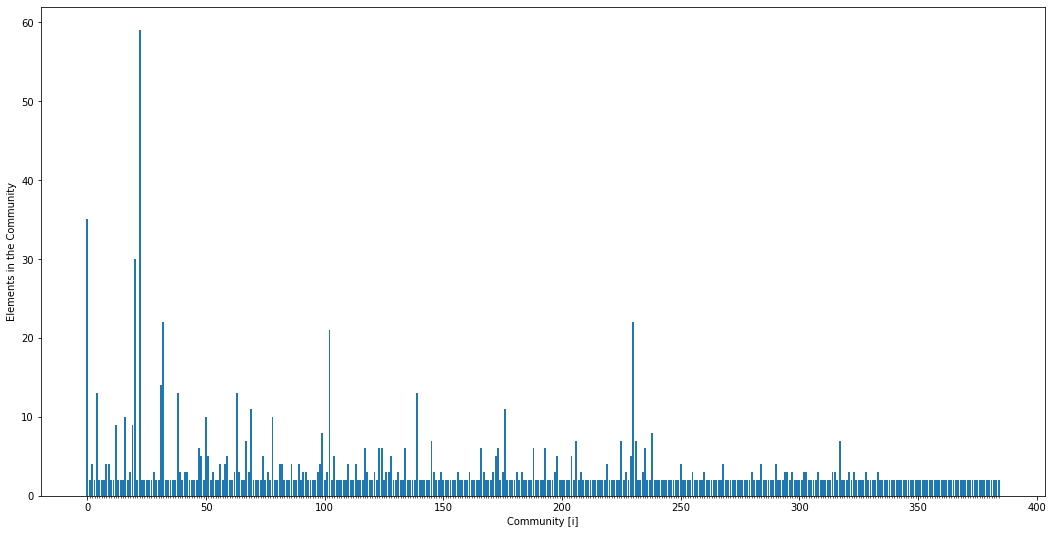

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)
ax.bar(range(len(elements_per_communities)), list(elements_per_communities.values()), align='center')
ax.set_xticks(range(len(elements_per_communities)), list(elements_per_communities.keys()))
ax.set_ylabel("Elements in the Community")
ax.set_xlabel("Community [i]")
plt.show()

## Labeling

In [ ]:
title, cluster = [], []
for i in partition.items():
    title.append(titles_no_code["clean_title"][i])
    cluster.append(i[1])
    
frame_clust = pd.DataFrame([pd.Series(title), pd.Series(cluster)]).transpose()
frame_clust.columns = ['Title', 'Cluster']

In [ ]:
frame_clust.shape

In [ ]:
frame_clust

In [ ]:
titles_no_code["clean_title"]

In [ ]:
U.clear()
V.clear()
W.clear()

In [ ]:
import networkx as nx
U = nx.Graph()
U.add_edges_from([(1,3), (1,4), (2,3), (2,4), (2,5), (1,6), (6,7), (6,8)])
nx.draw_networkx_labels(U, pos=nx.circular_layout(U))
nx.draw(U, pos=nx.circular_layout(U))

In [ ]:
V = nx.Graph()
V.add_edges_from([(5,1), (5,2), (5,3), (5,4), (5,6), (6,2)])
nx.draw_networkx_labels(V, pos=nx.circular_layout(V))
nx.draw(V, pos=nx.circular_layout(V))

In [ ]:
W = nx.Graph()
W.add_edges_from(U.edges)
W.add_edges_from(V.edges)

nx.draw_networkx_nodes(V, pos=nx.circular_layout(W), nodelist=V.nodes, node_color="red", node_size=10)
nx.draw_networkx_nodes(U, pos=nx.circular_layout(W), nodelist=U.nodes, node_color="blue", node_size=100)

nx.draw_networkx_edges(U, pos=nx.circular_layout(W), nodelist=U.edges, edge_color="gray");
nx.draw_networkx_edges(V, pos=nx.circular_layout(W), nodelist=V.edges, edge_color="k", style="dashed");
# nx.draw(W, pos=nx.circular_layout(W))

In [ ]:
W.weight